In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from numpy import save
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from urllib import request,error
from urllib.parse import urlparse
import json
import math
import sys
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets
import PIL
from PIL import Image
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import torchmetrics
from torchmetrics.functional import precision_recall
from torchmetrics import Precision

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def resize(img_path):    
    img = Image.open(img_path).convert('RGB')
    min_idx = [img.size[0],img.size[1]].index(min([img.size[0],img.size[1]]))
    new_size = [0,0]
    new_size[min_idx] = 224
    new_size[1-min_idx] = int((img.size[1-min_idx]*new_size[min_idx])/img.size[min_idx])
    img = img.resize(tuple(new_size), Image.ANTIALIAS)
    center = (new_size[0]//2,new_size[1]//2)
    img = img.crop((center[0]-112,center[1]-112,center[0]+112,center[1]+112))

    open_cv_image = np.array(img) 
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy() 
    return open_cv_image

In [ ]:
class CNN(nn.Module):
    def __init__(self,cfg):
        super(CNN, self).__init__()                 
        self.dropout = nn.Dropout(p=cfg["dropout"])
        self.k = cfg["kernel"]
        self.conv = cfg["conv"]
        # k=5
        # conv1(224*224*3->220*220*6)->pool(110*110*6)->
        # conv2(110*110*6->106*106*16)->pool(53*53*16)->
        # linear2(53*53*16->64)->linera(64->10)
        # conv3(53*53*16->49*49*32)->pool(24*24*32)->
        # linear3(24*24*32->64)->linera(64->10)
        # conv4(24*24*32->20*20*64)->pool(10*10*64)->
        # linear4(10*10*64->64)->linear(64->10)
        # k=3
        # conv1(224*224*3->222*222*6)->pool(111*111*6)->
        # conv2(111*111*6->109*109*16)->pool(54*54*16)->
        # linear2(54*54*16->64)->linera(64->10)
        # conv3(54*54*16->52*52*32)->pool(26*26*32)->
        # linear(26*26*32->64)->linera(64->10)

        if self.k == 5:
          if self.conv == 2:
            conv_out = 53*53*16
          elif self.conv == 3:
            conv_out = 24*24*32
          else:
            conv_out = 10*10*64
        else:
          if self.conv == 2:
            conv_out = 54*54*16
          else:
            conv_out = 26*26*32

        if self.conv == 2:
          self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=self.k,stride=1)
          self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=self.k,stride=1)
        elif self.conv ==3:
          self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=self.k,stride=1)
          self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=self.k,stride=1)
          self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=self.k,stride=1)
        else:
          self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=self.k,stride=1)
          self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=self.k,stride=1)
          self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=self.k,stride=1)
          self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.k,stride=1)

        self.dense1 = nn.Linear(conv_out,64)
        self.dense2 = nn.Linear(64,10)

        if cfg["activator"] == "relu":
          self.activator = F.relu
        else:
          self.activator = F.sigmoid

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)


    def forward(self, x):
        if self.conv == 2:
          x = self.pool(self.activator(self.conv1(x)))
          x = self.pool(self.activator(self.conv2(x)))
        elif self.conv == 3:
          x = self.pool(self.activator(self.conv1(x)))
          x = self.pool(self.activator(self.conv2(x)))
          x = self.pool(self.activator(self.conv3(x)))
        else:
          x = self.pool(self.activator(self.conv1(x)))
          x = self.pool(self.activator(self.conv2(x)))
          x = self.pool(self.activator(self.conv3(x)))
          x = self.pool(self.activator(self.conv4(x)))
        # print("forward:",x.shape)
        x = x.view(x.size(0), -1)
        x = self.activator(self.dense1(x))
        x = self.activator(self.dense2(x))

        return x

In [ ]:
driveroot = "drive/MyDrive/COMP9417/dataset/train"
cleanroot = os.path.join(driveroot,"clean")
transformed = os.path.join(driveroot,"transformed")

In [ ]:
configs = [
    # {"optim":"sgd","activator":"relu","lr":0.001,"ep":20,"batchsize":16,"dropout":0,"conv":2,"kernel":5,"dense":2},  
    # {"optim":"adam","activator":"relu","lr":0.001,"ep":20,"batchsize":16,"dropout":0,"conv":2,"kernel":5,"dense":2},
    # {"optim":"sgd","activator":"relu","lr":0.001,"ep":20,"batchsize":16,"dropout":0,"conv":3,"kernel":5,"dense":2}, 
    {"optim":"sgd","activator":"relu","lr":0.01,"ep":20,"batchsize":16,"dropout":0,"conv":3,"kernel":5,"dense":2},
    # {"optim":"sgd","activator":"relu","lr":0.01,"ep":20,"batchsize":32,"dropout":0.5,"conv":3,"kernel":5,"dense":2},
    # {"optim":"sgd","activator":"relu","lr":0.01,"ep":20,"batchsize":32,"dropout":0.5,"conv":3,"kernel":3,"dense":2},
    # =========================================== best one is the last 2 32-0.5-3-5-2
    # {"optim":"sgd","activator":"relu","lr":0.01,"ep":20,"batchsize":16,"dropout":0,"conv":4,"kernel":5,"dense":2}, #add layer
    # {"optim":"sgd","activator":"relu","lr":0.01,"ep":20,"batchsize":16,"dropout":0.5,"conv":3,"kernel":5,"dense":2}, #dropout
    # =========================================
    # {"optim":"sgd","activator":"sigmoid","lr":0.01,"ep":20,"batchsize":16,"dropout":0,"conv":3,"kernel":5,"dense":2}, #change activator  
    # {"optim":"adam","activator":"relu","lr":0.001,"ep":20,"batchsize":16,"dropout":0,"conv":3,"kernel":5,"dense":2},  # the best
    # {"optim":"adam","activator":"sigmoid","lr":0.001,"ep":20,"batchsize":16,"dropout":0,"conv":3,"kernel":5,"dense":2},
    # {"optim":"adam","activator":"relu","lr":0.001,"ep":80,"batchsize":16,"dropout":0,"conv":3,"kernel":5,"dense":2},
]

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model_path = os.path.join(driveroot,"model")

In [ ]:
X_train = np.load(os.path.join(transformed,"X_train.npy"))
y_train = np.load(os.path.join(transformed,"y_train.npy"))
X_val = np.load(os.path.join(transformed,"X_val.npy"))
y_val = np.load(os.path.join(transformed,"y_val.npy"))
X_test = np.load(os.path.join(transformed,"X_test.npy"))
y_test = np.load(os.path.join(transformed,"y_test.npy"))

In [ ]:
def train(cfg,X_data,y_data):
  X_tensor = torch.tensor(np.array(X_data)).to(device)
  y_tensor = torch.tensor(np.array(y_data)).to(device)
  data_loader = Data.DataLoader(dataset=Data.TensorDataset(X_tensor,y_tensor),batch_size=cfg["batchsize"],shuffle=True)

  model = CNN(cfg).to(device)

  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=cfg["lr"])
  if cfg["optim"] == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr= cfg["lr"])
  elif cfg["optim"] == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr= cfg["lr"])

  acc_list = []
  data_num = X_data.shape[0]

  for ep in tqdm(range(cfg["ep"])):
    correct = 0
    total = 0
    for i, data in enumerate(tqdm(data_loader), 0):
        current_loss = 0.0

        inputs, labels = data

        inputs = inputs.float() / 255
        labels = labels

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
    
    print('Loss after mini-batch %5d: %.3f' %(i + 1, current_loss / cfg["batchsize"]))
    
  print('Finished Training:',current_loss / cfg["batchsize"])

  PATH = os.path.join(model_path,f'cnn_{cfg["optim"]}_{cfg["activator"]}_lr={cfg["lr"]}_ep={cfg["ep"]}_batch={cfg["batchsize"]}_dropout={cfg["dropout"]}_kernel={cfg["kernel"]}_layer={cfg["conv"]}.pth')
  torch.save(model.state_dict(), PATH)

In [ ]:
def eval(file_root,cfg,X_train,y_train,X_val,y_val,X_test,y_test):
  
  X_tensor_train = torch.tensor(np.array(X_train)).to(device)
  y_tensor_train = torch.tensor(np.array(y_train)).to(device)
  train_loader = Data.DataLoader(dataset=Data.TensorDataset(X_tensor_train,y_tensor_train),batch_size=cfg["batchsize"],shuffle=True)
  X_tensor_val = torch.tensor(np.array(X_val)).to(device)
  y_tensor_val = torch.tensor(np.array(y_val)).to(device)
  val_loader = Data.DataLoader(dataset=Data.TensorDataset(X_tensor_val,y_tensor_val),batch_size=cfg["batchsize"],shuffle=True)
  X_tensor_test = torch.tensor(np.array(X_test)).to(device)
  y_tensor_test = torch.tensor(np.array(y_test)).to(device)
  test_loader = Data.DataLoader(dataset=Data.TensorDataset(X_tensor_test,y_tensor_test),batch_size=cfg["batchsize"],shuffle=True)

  model = CNN(cfg).to(device)
  PATH = os.path.join(file_root,f'cnn_{cfg["optim"]}_{cfg["activator"]}_lr={cfg["lr"]}_ep={cfg["ep"]}_batch={cfg["batchsize"]}_dropout={cfg["dropout"]}_kernel={cfg["kernel"]}_layer={cfg["conv"]}.pth')
  model.load_state_dict(torch.load(PATH))

  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=cfg["lr"])
  if cfg["optim"] == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr= cfg["lr"])
  elif cfg["optim"] == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr= cfg["lr"])

  acc_train_list = []
  loss_train_list = []
  acc_val_list = []
  loss_val_list = []
  acc_test_list = []
  loss_test_list = []

  for ep in tqdm(range(80)):
    correct_train = 0
    total_train = 0
    loss_train = 0.0
    correct_val = 0
    total_val = 0
    loss_val = 0.0
    correct_test = 0
    total_test = 0
    loss_test = 0.0
    # train 
    for i, data in enumerate(tqdm(train_loader), 0):
      current_loss = 0.0

      inputs, labels = data

      inputs = inputs.float() / 255
      labels = labels

      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      current_loss += loss.item()

      loss_train = current_loss / cfg["batchsize"]

      _, predicted = torch.max(outputs.data, 1)
      total_train += labels.size(0)
      correct_train += (predicted == labels).sum().item()
    
    # val
    with torch.no_grad():
      for i, data in enumerate(tqdm(val_loader),0):
        current_loss = 0.0
        inputs, labels = data
        inputs = inputs.float() / 255
        labels = labels

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = loss_func(outputs, labels)
        current_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

        loss_val = current_loss / cfg["batchsize"]
        # _, preds = torch.max(outputs, 1)
        # for t, p in zip(labels.view(-1), preds.view(-1)):
        #         confusion_matrix[t.long(), p.long()] += 1
    
    # test
    with torch.no_grad():
      for i, data in enumerate(tqdm(test_loader),0):
        current_loss = 0.0
        inputs, labels = data
        inputs = inputs.float() / 255
        labels = labels

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = loss_func(outputs, labels)
        current_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        loss_test = current_loss / cfg["batchsize"]
    
    acc_train = float(correct_train)/float(total_train)
    acc_val = float(correct_val)/float(total_val)
    acc_test = float(correct_test)/float(total_test)
    acc_train_list.append([ep,acc_train])
    loss_train_list.append([ep,loss_train])
    acc_val_list.append([ep,acc_val])
    loss_val_list.append([ep,loss_val])
    acc_test_list.append([ep,acc_test])
    loss_test_list.append([ep,loss_test])
    print(f'Accuracy of the network on train: {acc_train} vs ep loss: {loss_train}')
    print(f'Accuracy of the network on val: {acc_val} vs ep loss: {loss_val}')
    print(f'Accuracy of the network on test: {acc_test} vs ep loss: {loss_test}')

    save(os.path.join(driveroot,"evaluation","sgd_acc_ep_cnn_train.npy"),acc_train_list)
    save(os.path.join(driveroot,"evaluation","sgd_loss_ep_cnn_train.npy"),loss_train_list)
    save(os.path.join(driveroot,"evaluation","sgd_acc_ep_cnn_val.npy"),acc_val_list)
    save(os.path.join(driveroot,"evaluation","sgd_loss_ep_cnn_val.npy"),loss_val_list)
    save(os.path.join(driveroot,"evaluation","sgd_acc_ep_cnn_test.npy"),acc_test_list)
    save(os.path.join(driveroot,"evaluation","sgd_loss_ep_cnn_test.npy"),loss_test_list)

    # PATH = os.path.join(model_path,f'cnn_eval_sgd.pth')
    torch.save(model.state_dict(), PATH)

In [ ]:
eval(model_path,configs[0],X_train,y_train,X_val,y_val,X_test,y_test)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.4847222222222222 vs ep loss: 0.10204795747995377
Accuracy of the network on val: 0.275 vs ep loss: 0.11858215928077698
Accuracy of the network on test: 0.35833333333333334 vs ep loss: 0.1012667641043663


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.5125 vs ep loss: 0.09635305404663086
Accuracy of the network on val: 0.3958333333333333 vs ep loss: 0.08380668610334396
Accuracy of the network on test: 0.43333333333333335 vs ep loss: 0.12649479508399963


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.5236111111111111 vs ep loss: 0.0873594880104065
Accuracy of the network on val: 0.35833333333333334 vs ep loss: 0.0863465741276741
Accuracy of the network on test: 0.36666666666666664 vs ep loss: 0.1535957306623459


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.5527777777777778 vs ep loss: 0.06955063343048096
Accuracy of the network on val: 0.37916666666666665 vs ep loss: 0.1276680827140808
Accuracy of the network on test: 0.4041666666666667 vs ep loss: 0.10708606243133545


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.5430555555555555 vs ep loss: 0.10007545351982117
Accuracy of the network on val: 0.425 vs ep loss: 0.16044490039348602
Accuracy of the network on test: 0.4375 vs ep loss: 0.1157003715634346


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.5819444444444445 vs ep loss: 0.08294432610273361
Accuracy of the network on val: 0.3875 vs ep loss: 0.10053400695323944
Accuracy of the network on test: 0.3958333333333333 vs ep loss: 0.12540481984615326


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.5763888888888888 vs ep loss: 0.08789116144180298
Accuracy of the network on val: 0.3958333333333333 vs ep loss: 0.1313466578722
Accuracy of the network on test: 0.4083333333333333 vs ep loss: 0.10633906722068787


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.6 vs ep loss: 0.06648732721805573
Accuracy of the network on val: 0.42916666666666664 vs ep loss: 0.13489346206188202
Accuracy of the network on test: 0.4625 vs ep loss: 0.12391391396522522


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.6138888888888889 vs ep loss: 0.0905168429017067
Accuracy of the network on val: 0.4791666666666667 vs ep loss: 0.09079733490943909
Accuracy of the network on test: 0.475 vs ep loss: 0.10858620703220367


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.6638888888888889 vs ep loss: 0.02977924421429634
Accuracy of the network on val: 0.4625 vs ep loss: 0.10707101970911026
Accuracy of the network on test: 0.475 vs ep loss: 0.08013180643320084


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.7069444444444445 vs ep loss: 0.03704971447587013
Accuracy of the network on val: 0.42916666666666664 vs ep loss: 0.10265681147575378
Accuracy of the network on test: 0.44583333333333336 vs ep loss: 0.1710055023431778


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.7041666666666667 vs ep loss: 0.07940353453159332
Accuracy of the network on val: 0.48333333333333334 vs ep loss: 0.150357186794281
Accuracy of the network on test: 0.4625 vs ep loss: 0.09374647587537766


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.7430555555555556 vs ep loss: 0.09921541064977646
Accuracy of the network on val: 0.36666666666666664 vs ep loss: 0.1347154974937439
Accuracy of the network on test: 0.3875 vs ep loss: 0.10788104683160782


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.7972222222222223 vs ep loss: 0.03335074335336685
Accuracy of the network on val: 0.4708333333333333 vs ep loss: 0.12995433807373047
Accuracy of the network on test: 0.475 vs ep loss: 0.0762510672211647


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.8291666666666667 vs ep loss: 0.0649513527750969
Accuracy of the network on val: 0.4708333333333333 vs ep loss: 0.12566569447517395
Accuracy of the network on test: 0.5166666666666667 vs ep loss: 0.16285403072834015


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.8027777777777778 vs ep loss: 0.04841562360525131
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.13865000009536743
Accuracy of the network on test: 0.44166666666666665 vs ep loss: 0.1001100093126297


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.85 vs ep loss: 0.03059570863842964
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.11661417782306671
Accuracy of the network on test: 0.49583333333333335 vs ep loss: 0.10276636481285095


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9277777777777778 vs ep loss: 0.005497007165104151
Accuracy of the network on val: 0.4583333333333333 vs ep loss: 0.23751981556415558
Accuracy of the network on test: 0.5208333333333334 vs ep loss: 0.10500839352607727


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9444444444444444 vs ep loss: 0.021919578313827515
Accuracy of the network on val: 0.4708333333333333 vs ep loss: 0.15918618440628052
Accuracy of the network on test: 0.5166666666666667 vs ep loss: 0.1778203248977661


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9597222222222223 vs ep loss: 0.0014778681797906756
Accuracy of the network on val: 0.45 vs ep loss: 0.20104879140853882
Accuracy of the network on test: 0.5125 vs ep loss: 0.19020888209342957


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.0013063226360827684
Accuracy of the network on val: 0.4625 vs ep loss: 0.22656334936618805
Accuracy of the network on test: 0.5 vs ep loss: 0.20843681693077087


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009144862182438374
Accuracy of the network on val: 0.45 vs ep loss: 0.23531277477741241
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.14516238868236542


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009460174478590488
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.15735217928886414
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.24925486743450165


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 6.576021405635402e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.21601688861846924
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.1912979781627655


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.0001417097228113562
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.1796557903289795
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.10966496914625168


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009163263253867626
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.19483639299869537
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.11596360802650452


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.00014975898375269026
Accuracy of the network on val: 0.45 vs ep loss: 0.1885397583246231
Accuracy of the network on test: 0.5125 vs ep loss: 0.12786494195461273


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.00013404448691289872
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.18778319656848907
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.13260358572006226


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.018080420792102814
Accuracy of the network on val: 0.43333333333333335 vs ep loss: 0.25233131647109985
Accuracy of the network on test: 0.5125 vs ep loss: 0.12199089676141739


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009042452089488506
Accuracy of the network on val: 0.4375 vs ep loss: 0.28160005807876587
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.20157486200332642


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 6.730639142915606e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.20195217430591583
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.12391490489244461


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 6.260925147216767e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.17260584235191345
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.28028959035873413


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.0001627082674531266
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.2684878706932068
Accuracy of the network on test: 0.5 vs ep loss: 0.28613021969795227


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 4.853829523199238e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.23680457472801208
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.2236516773700714


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009046501480042934
Accuracy of the network on val: 0.43333333333333335 vs ep loss: 0.314663290977478
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.29363468289375305


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 6.890691292937845e-05
Accuracy of the network on val: 0.4375 vs ep loss: 0.20121003687381744
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.1595083773136139


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 3.7157980841584504e-05
Accuracy of the network on val: 0.4375 vs ep loss: 0.1752738207578659
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.14894850552082062


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 5.857773430761881e-05
Accuracy of the network on val: 0.43333333333333335 vs ep loss: 0.21828018128871918
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.255827397108078


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 9.659349598223343e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.16924753785133362
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.18760967254638672


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.9296767024789006e-05
Accuracy of the network on val: 0.4375 vs ep loss: 0.2528684735298157
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.25079184770584106


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009026912972331047
Accuracy of the network on val: 0.43333333333333335 vs ep loss: 0.18497234582901
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.09100150316953659


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009034441784024239
Accuracy of the network on val: 0.4375 vs ep loss: 0.19932669401168823
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.21014559268951416


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 3.651119550340809e-05
Accuracy of the network on val: 0.45 vs ep loss: 0.2277992069721222
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.26098817586898804


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 5.1154107495676726e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.2365347146987915
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.26884594559669495


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.2797565179644153e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.15840692818164825
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.2188335657119751


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009020685218274593
Accuracy of the network on val: 0.4375 vs ep loss: 0.21139758825302124
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.17463986575603485


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 3.594113513827324e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.2503940463066101
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.3331688940525055


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.295369813509751e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.3274558484554291
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.19397127628326416


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009024369530379772
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.09540154784917831
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.23207314312458038


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 1.3615028365165927e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.350739061832428
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.30794569849967957


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 3.360113623784855e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.09616169333457947
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.2868345081806183


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009020614437758923
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.35489919781684875
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.25509029626846313


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.6134332074434496e-05
Accuracy of the network on val: 0.45 vs ep loss: 0.27653229236602783
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.19637247920036316


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.017996780574321747
Accuracy of the network on val: 0.45 vs ep loss: 0.34329754114151
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.25969550013542175


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009035231545567513
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.23677659034729004
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.16236621141433716


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 9.409813173988368e-06
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.2816743552684784
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.26348650455474854


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 3.05170142382849e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.2915080189704895
Accuracy of the network on test: 0.5 vs ep loss: 0.30949118733406067


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.5899740649037994e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.14695678651332855
Accuracy of the network on test: 0.5 vs ep loss: 0.32465100288391113


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.6683061150833964e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.3148387372493744
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.14896459877490997


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 3.2538991945330054e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.27463674545288086
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.3402050733566284


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 1.6787562344688922e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.2748360335826874
Accuracy of the network on test: 0.5125 vs ep loss: 0.17945247888565063


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009015414863824844
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.2526872158050537
Accuracy of the network on test: 0.5125 vs ep loss: 0.14431536197662354


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 1.2113362572563346e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.2071092426776886
Accuracy of the network on test: 0.5125 vs ep loss: 0.12785255908966064


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.0154860976617783e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.24178200960159302
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.3528937101364136


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 3.09468996420037e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.1402975171804428
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.19925157725811005


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.017998255789279938
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.20338435471057892
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.19234080612659454


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009011048823595047
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.16021400690078735
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.3165929913520813


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 1.8013301087194122e-05
Accuracy of the network on val: 0.45 vs ep loss: 0.3123559057712555
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.20975077152252197


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.375432086410001e-05
Accuracy of the network on val: 0.45 vs ep loss: 0.2954188883304596
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.2622988820075989


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 1.3872137969883624e-05
Accuracy of the network on val: 0.45 vs ep loss: 0.2742900550365448
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.10610982775688171


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 5.3719627430837136e-06
Accuracy of the network on val: 0.45 vs ep loss: 0.28680485486984253
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.26335373520851135


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 1.428529321856331e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.21050623059272766
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.3411586582660675


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.0081242837477475e-05
Accuracy of the network on val: 0.45 vs ep loss: 0.23404130339622498
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.16912955045700073


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 0.009019632823765278
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.20391900837421417
Accuracy of the network on test: 0.5 vs ep loss: 0.174672469496727


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 1.0590800229692832e-05
Accuracy of the network on val: 0.44583333333333336 vs ep loss: 0.28443148732185364
Accuracy of the network on test: 0.5 vs ep loss: 0.27460548281669617


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 9.291442438552622e-06
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.19083137810230255
Accuracy of the network on test: 0.5 vs ep loss: 0.34595832228660583


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 9.52000391407637e-06
Accuracy of the network on val: 0.45 vs ep loss: 0.2554551661014557
Accuracy of the network on test: 0.5041666666666667 vs ep loss: 0.3814006447792053


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 2.7169340683030896e-05
Accuracy of the network on val: 0.44166666666666665 vs ep loss: 0.3293377161026001
Accuracy of the network on test: 0.5 vs ep loss: 0.1866997629404068


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 1.4683449080621358e-05
Accuracy of the network on val: 0.45 vs ep loss: 0.1850591003894806
Accuracy of the network on test: 0.5083333333333333 vs ep loss: 0.29143035411834717


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy of the network on train: 0.9666666666666667 vs ep loss: 1.0399668099125847e-05
Accuracy of the network on val: 0.45 vs ep loss: 0.13638564944267273
Accuracy of the network on test: 0.5125 vs ep loss: 0.25177881121635437


In [ ]:
def test(cfg,X_data,y_data):
  X_tensor = torch.tensor(np.array(X_data)).to(device)
  y_tensor = torch.tensor(np.array(y_data)).to(device)
  data_loader = Data.DataLoader(dataset=Data.TensorDataset(X_tensor,y_tensor),batch_size=len(y_data),shuffle=True)

  model = CNN(cfg).to(device)

  PATH = os.path.join(model_path,f'cnn_{cfg["optim"]}_{cfg["activator"]}_lr={cfg["lr"]}_ep={cfg["ep"]}_batch={cfg["batchsize"]}_dropout={cfg["dropout"]}_kernel={cfg["kernel"]}_layer={cfg["conv"]}.pth')
  model.load_state_dict(torch.load(PATH))

  correct = 0  # 250 pair each 16 images
  data_num = X_data.shape[0]  # total data number of validation set

  acc_list = []
  # since we're not training, we don't need to calculate the gradients for our outputs
  correct = 0
  total = 0
  confusion_matrix = torch.zeros(10, 10)
  with torch.no_grad():
      for i, data in enumerate(data_loader, 0):
          inputs, labels = data
          inputs = inputs.float() / 255
          labels = labels

          inputs, labels = inputs.to(device), labels.to(device)

          outputs = model(inputs)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          recall = precision_recall(predicted, labels, average='macro', num_classes=10)
          print(recall)
          precision = Precision(average='macro', num_classes=10)
          print(precision)

          _, preds = torch.max(outputs, 1)
          for t, p in zip(labels.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  

          # for k in range(outputs.shape[0]):
          #     if outputs[k] < 0.5:  # low prob, predict without mask
          #         if labels[k] == 0:  # if label is 0 (without mask), then predict correctly
          #             val_correct += 1
          #     else:  # high prob, predict with mask
          #         if labels[k] == 1:  # if label is 1 (wearing mask), then predict correctly
          #             val_correct += 1

  # print(f"val acc: {val_correct / val_data_num}")
  print(f'{cfg} \n Accuracy of the network on the {len(y_data)} test images: {100 * correct // total} %')

  import seaborn as sns
  import matplotlib.pyplot as plt

  cf_matrix = confusion_matrix

  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('Confusion Matrix for CNN\n\n');
  ax.set_xlabel('\nPredicted Class')
  ax.set_ylabel('Actual Class');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])
  ax.yaxis.set_ticklabels(['0','1', '2', '3', '4', '5', '6', '7', '8', '9'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

(tensor(0.3333), tensor(0.4284))
Precision()
{'optim': 'adam', 'activator': 'relu', 'lr': 0.001, 'ep': 80, 'batchsize': 16, 'dropout': 0, 'conv': 3, 'kernel': 5, 'dense': 2} 
 Accuracy of the network on the 240 test images: 38 %


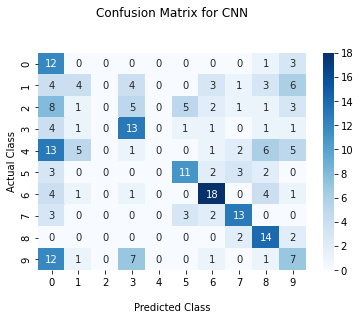

In [ ]:
for cfg in configs:
  test(cfg,X_test,y_test)

In [ ]:
for cfg in tqdm(configs):
  train(cfg,X_train,y_train)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Loss after mini-batch    45: 0.142


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.144


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.143


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.144


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.142


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.144


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.144


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.142


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.144


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.144


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.142


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.145


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.143


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.145


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.142


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.143


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.144


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.142


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.143


  0%|          | 0/45 [00:00<?, ?it/s]

Loss after mini-batch    45: 0.143
Finished Training: 0.14345206320285797
